<font size=4>
    Here, is a quick and direct implementation of URF protocol.
    <br><br>

### Requirements <br>
<font size=4>
    X - input data <br>
</font>
<font size=3>
    &emsp; a high dimensional 2d numpy array <br>
    &emsp; if input data from multiple MD trajectories, then X has to be concatednated <br>
    &emsp; in the original work, only continuous data was tested, coming from internal coordiantes of proteins via MD simulations <br><br>

In [1]:
import numpy as np

In [9]:
X = np.load('../data/input_data.npy')
X.shape

(159729, 3741)

### URF

In [2]:
import sys
sys.path.append('../URF/')
from model import unsupervised_random_forest as urf

In [7]:
dobj = urf(**args)              # initilization step, 
dobj.fit(X)                     # fitting step 
lc, fimp = dobj.get_output()    # predicting step

### outputs 
<br>
<font size=4>
    Learning Coefficient (LC): <br>
</font>
<font size=3>
    &emsp; an internal metric of URF learning, which indicates its performance <br>
    &emsp; it cn range [0-1], but generally observed either close to zero or close to 1 <br>
    &emsp; high values indicate higher performance <br>
    &emsp; it contains a value for each cross validation iteration of RF2 <br>
</font>
<br> 
<font size=4>
    feature importance scores (fimp): <br>
</font>
<font size=3>
    &emsp; a feature importance score/weight for each feature and cross validation iteration <br>
    &emsp; based on these scores, feature selections can be performed <br>
    &emsp; high score indicate more importance <br> <br>

### hyper-parameters
<br>
<font size=4>
    All steps can be controlled via user-defined hyper-parameter settings. Specifically,  <br> <br>
    $pmt\_alg$ <br>
</font>
<font size=3>
    &emsp; for the efficient use based on memory availability <br>
    &emsp; E ['ef', 'fp', 'lm'] #available schemes <br>
    &emsp; URF protocol can raise $memory\_warning$ prior to fitting, given data and machine specifications <br>
    <br>
</font>
<font size=4>
    $pmt\_data\_size$ <br>
</font>
<font size=3>    
    &emsp; E [0-1] <br>
    &emsp; incase of low memory or very large data, this hyperparameter can reduce memory, without loss of performance <br><br>
</font>
<font size=4>
    $n_{hc}$ <br>
</font>
<font size=3>
    &emsp; number of hierarchical classes in data <br>
    &emsp; by default checks between 2-10 <br>
    &emsp; URF protocol can stop at this stage (for default settings), if $pre\_LC\_estimation$ is detected low <br><br>
</font>
<font size=4>
    $rf1\_cv, rf2\_cv$ <br>
</font>
<font size=3>
    &emsp; number of cross validations for RF
    <br> <br> <br>
</font>
<font size=4>
    The below are complete list of hyper-parameter options available <br>

In [5]:
print(urf.__doc__)


    a feature selection pipeline based on unsupervised (self-supervised) random forest as 
    defined in citation_here.

    usage:
        from model import unsupervised_random_forest as urf
        dobj = urf(**args)
        dobj.fit(data)
        lc, fimp = dobj.get_output()

    INPUTS::
        random_state    - [int] d[42] a random integer to set the random seed

        syn_data_type   - [str] d[permute]
                            type of synthetic data to generate
                            random   - randomly selects some of the datapoints from original data
                                        and labelled them as synthetic data
                            marginal - also randomly selects data but tries to maintain the marginal
                                        distribution similar to original data
                                        its the same copy as original data with syn_dat_size=1
                            permute  - it randomly permute the columns (

### specific cases
<br>
<font size=4>
    $restarting$ $the$ $fitting$ $step$ <br>
</font>
<font size=3>
    &emsp; the dobj.fit(X) step may stop in between raising the $pre\_LC\_warning$, if no internal structure is detected via default settings <br>
    &emsp; here, the fitting step can be restarted via $dobj.restart\_fit(X, n_{hc})$ attribute, <br>
    &emsp; this way, the fitting restarts from checkpoint, rather than from the start, saving time <br><br>
</font>

In [9]:
dobj = urf(**args)
dobj.fit(X)
lc, fimp = dobj.get_output()

AssertionError: best nhc cound not be found within 2-10 
 you may try restart_fit with defined nhc

In [11]:
# restarting as
dobj.restart_fit(X, nhc=12)
lc, fimp = dobj.get_output()

### An example

In [12]:
X = np.load('../1_datasets/mopR_bindings/s229_dists.npz')
X = [X[i] for i in list(X)]  #129 trajectories
X = np.concatenate((X))
X.shape

(2897865, 229)

In [13]:
dobj = urf(pmt_alg='ef', pmt_data_size=0.1)
dobj.fit(X)
lc, fimp = dobj.get_output()

In [15]:
lc

array([0.9968177 , 0.99732551, 0.9969578 , 0.99736382, 0.99732083])

In [18]:
fimp.shape  # for 5 cross validations and a value for each feature

(5, 229)

In [21]:
import matplotlib.pyplot as plt

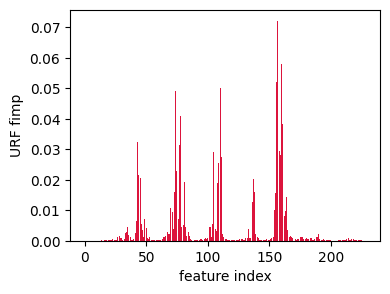

In [28]:
plt.bar(range(fimp.shape[1]), np.mean(fimp, axis=0), color='crimson')
plt.ylim(0,)
plt.xlabel('feature index')
plt.ylabel('URF fimp')
plt.show()

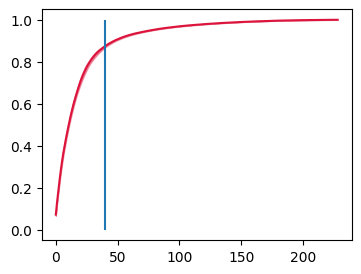

array([0.86845002, 0.88167903, 0.87529526, 0.87972878, 0.86781226])

In [33]:
cumsum = [np.cumsum(i[i.argsort()[::-1]]) for i in fimp]
plt.fill_between(range(fimp.shape[1]), 
                 np.mean(cumsum, axis=0)-np.std(cumsum, axis=0), np.mean(cumsum, axis=0)+np.std(cumsum,axis=0),
                color='crimson', alpha=0.4)
plt.plot(range(fimp.shape[1]), np.mean(cumsum, axis=0), color='crimson')
plt.vlines([40],0,1,)
plt.show()
np.array(cumsum)[:,40]

In [ ]:
#taking top 40 features, which together constitutes ~0.87/1 importance